# Epidemiological dynamics

 > This chapter introduces the basic deterministic models of infectious disease dynamics (SIR), focusing on threshold behaviour ($R_0$), vaccination (herd immunity), demography (endemic equilibria), and seasonal forcing (multi-year cycles).
 >
 > It reuses the same ODE toolkit as earlier chapters, but the interaction here is between **hosts and infection status** rather than between species.
 >
 > References: {cite:t}`KermackMcKendrick1927`; {cite:t}`AndersonMay1991`; {cite:t}`KeelingRohani2008`.

```{note} Conventions used here
- $S(t)$: susceptible fraction (or count)
- $I(t)$: infectious fraction (or count)
- $R(t)$: recovered/removed fraction (or count)
```

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp


---

## Basic SIR model (no demography)

A standard SIR model is:

$$
\begin{aligned}
\dot S &= -\beta SI,\\
\dot I &= \beta SI - \gamma I,\\
\dot R &= \gamma I.
\end{aligned}
$$

Here:
- $\beta$ is the transmission parameter (contact × transmission probability)
- $\gamma$ is the recovery rate; mean infectious period is $1/\gamma$

If $S(0)+I(0)+R(0)=1$ (fractions), then $S+I+R=1$ is conserved.

### Early growth and $R_0$
At the start of an outbreak, $S\approx S(0)$ is near 1.
Then

$$
\dot I \approx (\beta S(0) - \gamma) I.
$$

So infections grow initially if $\beta S(0) > \gamma$.
Define the **basic reproduction number** (in this normalised setting):

$$
R_0 = \frac{\beta}{\gamma}.
$$

More generally, if $S(0)\neq 1$, early growth is controlled by $R_0 S(0)$.

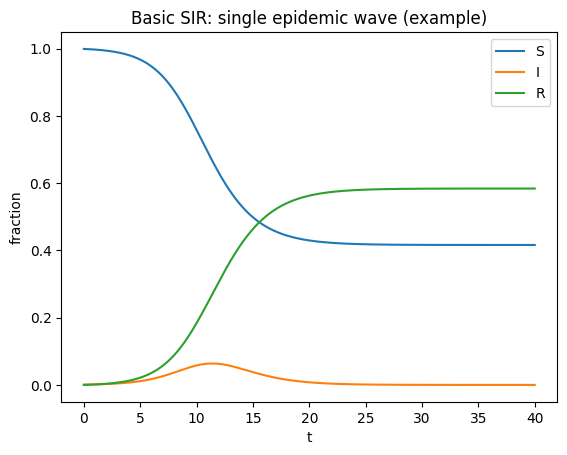

In [2]:
def sir_rhs(t, y, beta, gamma):
    S,I,R = y
    return [-beta*S*I, beta*S*I - gamma*I, gamma*I]

def simulate_sir(beta=1.5, gamma=1.0, y0=(0.999, 0.001, 0.0), t_end=20, n=2000):
    t_eval=np.linspace(0,t_end,n)
    sol = solve_ivp(lambda t,y: sir_rhs(t,y,beta,gamma), (0,t_end), list(y0),
                    t_eval=t_eval, rtol=1e-9, atol=1e-12)
    return sol.t, sol.y

t,(S,I,R) = simulate_sir(beta=1.5, gamma=1.0, t_end=40)

plt.figure()
plt.plot(t,S,label="S")
plt.plot(t,I,label="I")
plt.plot(t,R,label="R")
plt.xlabel("t"); plt.ylabel("fraction")
plt.title("Basic SIR: single epidemic wave (example)")
plt.legend(); plt.show()


## Vaccination and herd immunity

If a fraction $p$ of the population is immune at the start (perfect vaccination),
the initial susceptible fraction is $S(0)=1-p$.

Initial growth requires:

$$
\beta(1-p) > \gamma
\quad\Leftrightarrow\quad
(1-p)R_0 > 1.
$$

So the critical vaccination coverage is:

$$
p_c = 1 - \frac{1}{R_0}.
$$

This is the classic herd immunity threshold.

## SIR with demography (births and deaths)

To model an endemic infection, include per-capita birth/death rate $\mu$:

$$
\begin{aligned}
\dot S &= \mu - \beta SI - \mu S,\\
\dot I &= \beta SI - \gamma I - \mu I,\\
\dot R &= \gamma I - \mu R.
\end{aligned}
$$

(Here we have normalised so total population is 1.)

Then susceptibles are replenished by births, so infections can persist (endemic equilibrium) if $R_0>1$.

A common form of $R_0$ here is:

$$
R_0 = \frac{\beta}{\gamma + \mu}.
$$

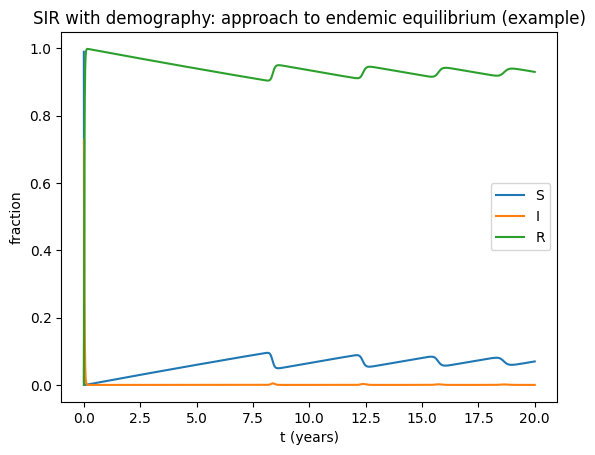

In [3]:
def sir_demo_rhs(t, y, beta, gamma, mu):
    S,I,R = y
    return [mu - beta*S*I - mu*S,
            beta*S*I - gamma*I - mu*I,
            gamma*I - mu*R]

def simulate_sir_demo(beta=750, gamma=52, mu=0.0125, y0=(0.99,0.01,0.0), t_end=10, n=5000):
    t_eval=np.linspace(0,t_end,n)  # time in years
    sol = solve_ivp(lambda t,y: sir_demo_rhs(t,y,beta,gamma,mu), (0,t_end), list(y0),
                    t_eval=t_eval, rtol=1e-9, atol=1e-12)
    return sol.t, sol.y

t,(S,I,R)=simulate_sir_demo(beta=750, gamma=52, mu=0.0125, t_end=20)

plt.figure()
plt.plot(t,S,label="S")
plt.plot(t,I,label="I")
plt.plot(t,R,label="R")
plt.xlabel("t (years)"); plt.ylabel("fraction")
plt.title("SIR with demography: approach to endemic equilibrium (example)")
plt.legend(); plt.show()


## Periodically forced SIR (seasonality)

Seasonality can be represented by periodic forcing of $\beta$:

$$
\beta(t) = \beta_0\,(1 + \mathrm{amp}\,\sin(\omega t)).
$$

With forcing, the system is **non-autonomous** and can show:
- annual cycles
- multi-year cycles (e.g. 2-cycle, 3-cycle)
- more complex (even chaotic) dynamics for some parameter ranges

A practical way to diagnose an $n$-cycle is via a **stroboscopic/Poincaré map**:
sample the state once per forcing period and look for repeating patterns.

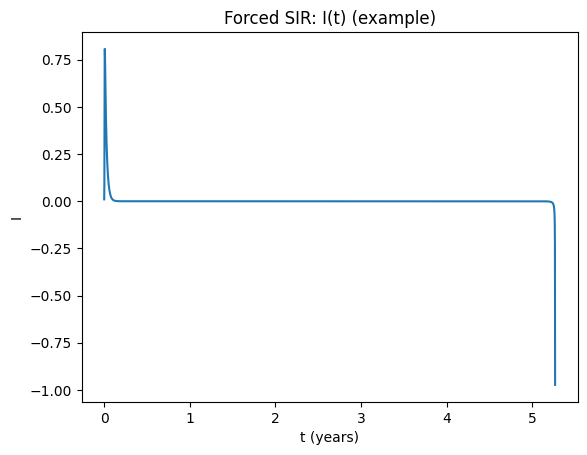

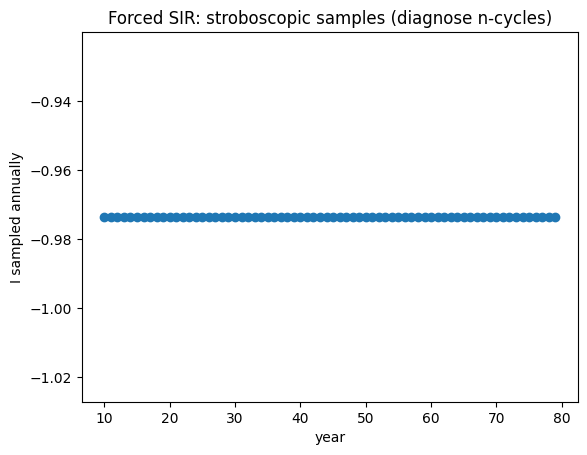

In [4]:
def sir_forced_rhs(t, y, beta0, amp, omega, gamma, mu):
    S,I,R = y
    beta = beta0*(1 + amp*np.sin(omega*t))
    return [mu - beta*S*I - mu*S,
            beta*S*I - gamma*I - mu*I,
            gamma*I - mu*R]

def simulate_sir_forced(beta0=1200, amp=0.08, omega=2*np.pi, gamma=50, mu=0.0125,
                        y0=(0.99,0.01,0.0), t_end=200, step=0.002):
    # time in years; step ~ 0.002 years ~ 0.73 days
    t_eval = np.arange(0, t_end+step, step)
    sol = solve_ivp(lambda t,y: sir_forced_rhs(t,y,beta0,amp,omega,gamma,mu),
                    (0,t_end), list(y0), t_eval=t_eval, rtol=1e-8, atol=1e-10)
    return sol.t, sol.y

t,(S,I,R)=simulate_sir_forced(beta0=1200, amp=0.08, omega=2*np.pi, gamma=50, mu=0.0125, t_end=80)

plt.figure()
plt.plot(t,I)
plt.xlabel("t (years)"); plt.ylabel("I")
plt.title("Forced SIR: I(t) (example)")
plt.show()

# Poincaré sampling once per year
T = 2*np.pi/(2*np.pi)  # with omega=2*pi, period is 1 year
years = np.arange(10, 80, 1.0)
I_sample = np.interp(years, t, I)

plt.figure()
plt.plot(years, I_sample, marker="o", linestyle="none")
plt.xlabel("year"); plt.ylabel("I sampled annually")
plt.title("Forced SIR: stroboscopic samples (diagnose n-cycles)")
plt.show()


---

## Summary
- In the basic SIR model, early epidemic growth occurs when $R_0 S(0) > 1$; in the fully susceptible limit $S(0)\approx 1$, this reduces to the familiar threshold $R_0>1$.
- Vaccination reduces the initial susceptible fraction; the herd-immunity threshold in the simplest setting is $p_c = 1 - 1/R_0$.
- Adding demography ($\mu$) replenishes susceptibles and allows endemic equilibria; a common threshold form is $R_0 = \beta/(\gamma+\mu)$.
- Seasonal forcing makes the system non-autonomous and can generate multi-year cycles that are easy to diagnose using stroboscopic (Poincaré) sampling.